# Project milestone 2

## Libraries
*To run the notebook install all these packages using pip install <name_package>* 
- pandas
- numpy 
- matplotlib
- seaborn
- pickle
- folium
- geopy
- IPyhton
- statsmodels
- sklearn.linear_model
- os

## Data
This dataset consists of beer reviews from two Beer rating websites: BeerAdvocate and RateBeer, for a period of 17 years ranging from 2001 to 2017.  
Two folder are present for the Data: BeerAdvocate and RateBeer. Each one contains those respective files:
- beers.csv
- breweries.csv
- users.csv
- ratings.txt.

This is important to make sure that the files are in this architecture to run the notebook.

## Idea of project 
This project aims mainly at studying the beer trends based on seasons. In fact, each individual may tend to consume different beers based on its mood or feeling influenced by the season.

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import folium
from geopy.geocoders import Nominatim
from IPython.display import display
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
import os
%run helper_functions.ipynb

**Import first datasets**

In [2]:
FOLDER_BA = './BeerAdvocate/'
beers_ba = pd.read_csv(FOLDER_BA + 'beers.csv')
breweries_ba = pd.read_csv(FOLDER_BA + 'breweries.csv')
users_ba = pd.read_csv(FOLDER_BA + 'users.csv')

FOLDER_RB = './RateBeer/'
beers_rb = pd.read_csv(FOLDER_RB + 'beers.csv')
breweries_rb = pd.read_csv(FOLDER_RB + 'breweries.csv')
users_rb = pd.read_csv(FOLDER_RB + 'users.csv')

**Converting .txt to dataframe** (make sure to have a 8 Go of RAM)  
Note: This code converts ratings.txt to .csv file (ratings_clean), only if they do not exist. Thus the .csv will only be formed once (during the first run of the notebook). 

In [3]:
#Check for presence of 'ratings_ba_clean.csv'
if not os.path.isfile(FOLDER_BA + 'ratings_ba_clean.csv'):
    
    #Convert .txt to dataframe
    ratings_ba = text_to_df(FOLDER_BA + 'ratings.txt')
    
    #Convert .txt to dataframe
    ratings_ba.to_csv(FOLDER_BA + 'ratings_ba_clean.csv')
else:
    print('file already present')

#Check for presence of 'ratings_rb_clean.csv'
if not os.path.isfile(FOLDER_RB + 'ratings_rb_clean.csv'):
    
    #Convert .txt to dataframe
    ratings_rb = text_to_df(FOLDER_RB + 'ratings.txt')
    
    #Convert .txt to dataframe
    ratings_rb.to_csv(FOLDER_RB + 'ratings_rb_clean.csv')
else:
    print('file already present')

file already present
file already present


**Import ratings datasets and cache the data**  
Note: As the 'ratings_clean.csv' files are relatively heavy, we are going to save them in cache memory, so the loading time will not be too long. This will be done once, as the code below checks for the presence or not of the .pkl to load and cache the data

In [4]:
#Check for presence of 'ratings_ba.pkl' (BeerAdvocate)
if not os.path.isfile('ratings_ba.pkl'):
    
    #Load the newly created .csv file
    ratings_ba_csv = pd.read_csv(FOLDER_BA + 'ratings_ba_clean.csv')
    
    #Cache the data
    pickle.dump(ratings_ba_csv, open('ratings_ba.pkl', 'wb'))
else:
    print('file already loaded and cached')

#Check for presence of 'ratings_rb.pkl' (RateBeer)
if not os.path.isfile('ratings_rb.pkl'):
    
    #Load the newly created .csv file
    ratings_rb_csv = pd.read_csv(FOLDER_RB + 'ratings_rb_clean.csv')
    
     #Cache the data
    pickle.dump(ratings_rb_csv, open('ratings_rb.pkl', 'wb'))
else:
    print('file already loaded and cached')

file already loaded and cached
file already loaded and cached


## 0. Load the cached data

In [5]:
# Load data from 'ratings_ba.pkl' & 'ratings_rb.pkl' file
ratings_ba = pickle.load(open('ratings_ba.pkl', 'rb'))
ratings_rb = pickle.load(open('ratings_rb.pkl', 'rb'))

## 1. Pre-processing datasets for BeerAdvocate and RateBeer

In [6]:
ratings_rb.head(1)

,Unnamed: 0,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."


In [7]:
users_rb.head(1)

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland


**1.1 Merge users and ratings to obtain location of each rating especially**

In [8]:
# merge by a *right join*, 'user' dataframe & 'rating' dataframe based on the 'user_id' column
# the matching rows from the 'users' DataFrame will be included on all rows from the 'ratings' dataframe
user_ratings_ba = users_ba.merge(ratings_ba, how = 'right', on = 'user_id')
user_ratings_rb= users_rb.merge(ratings_rb, how = 'right', on = 'user_id')

In [9]:
print(user_ratings_ba.shape, user_ratings_rb.shape)

(8393032, 23) (7123806, 21)


In [10]:
user_ratings_ba.head(1)

,nbr_ratings,nbr_reviews,user_id,user_name_x,joined,location,Unnamed: 0,beer_name,beer_id,brewery_name,...,date,user_name_y,appearance,aroma,palate,taste,overall,rating,text,review
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington",0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),...,1440064800,nmann08,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True


In [11]:
user_ratings_rb.head(1)

,nbr_ratings,user_id,user_name_x,joined,location,Unnamed: 0,beer_name,beer_id,brewery_name,brewery_id,...,abv,date,user_name_y,appearance,aroma,palate,taste,overall,rating,text
0,1890.0,175852,Manslow,1.337508e+09,Poland,0,33 Export (Gabon),410549,Sobraga,3198,...,5.0,1461664800,Manslow,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."


**1.2 Change the date format and isolate month and year**

In [12]:
user_ratings_ba['date'] = pd.to_datetime(user_ratings_ba['date'], unit='s')
user_ratings_rb['date'] = pd.to_datetime(user_ratings_rb['date'], unit='s')

In [13]:
user_ratings_ba['joined'] = pd.to_datetime(user_ratings_ba['joined'], unit='s')
user_ratings_rb['joined'] = pd.to_datetime(user_ratings_rb['joined'], unit='s')

In [14]:
user_ratings_ba['date'].head()

0   2015-08-20 10:00:00
1   2009-02-20 11:00:00
2   2006-03-13 11:00:00
3   2004-12-01 11:00:00
4   2004-08-30 10:00:00
Name: date, dtype: datetime64[ns]

In [15]:
# add columns 'month' & 'year' & 'year_month' on 'user_ratings' dataframe
user_ratings_ba['month'] = user_ratings_ba['date'].dt.month
user_ratings_ba['year'] = user_ratings_ba['date'].dt.year
user_ratings_rb['month'] = user_ratings_rb['date'].dt.month
user_ratings_rb['year'] = user_ratings_rb['date'].dt.year

In [16]:
user_ratings_ba['year_month'] = user_ratings_ba['date'].dt.to_period('M')
user_ratings_rb['year_month'] = user_ratings_rb['date'].dt.to_period('M')

## 2. Data Cleaning 
**2.1 Remove unrelevant columns/duplicates**

In [17]:
user_ratings_ba.drop(['Unnamed: 0', 'user_name_y'], axis = 1, inplace = True)
user_ratings_rb.drop(['Unnamed: 0', 'user_name_y'], axis = 1, inplace = True)

In [18]:
user_ratings_ba.rename(columns = {'user_name_x': 'user_name'}, inplace = True)
user_ratings_rb.rename(columns = {'user_name_x': 'user_name'}, inplace = True)

**2.2 Identification of columns that have missing values**  

In [19]:
user_ratings_ba.columns[user_ratings_ba.isna().any()].tolist()

['user_name',
 'joined',
 'location',
 'abv',
 'appearance',
 'aroma',
 'palate',
 'taste',
 'overall',
 'text']

In [20]:
user_ratings_rb.columns[user_ratings_rb.isna().any()].tolist()

['nbr_ratings', 'user_name', 'joined', 'location', 'abv', 'text']

**2.3 Replace abv (alcohol degree) missing values by the average abv of the corresponding beer style**

In [21]:
missing_values_abv_ba = user_ratings_ba['abv'].isna().mean() * 100
missing_values_abv_rb = user_ratings_rb['abv'].isna().mean() * 100

In [22]:
print(f"users_ratings_ba has {missing_values_abv_ba:.2f}% missing values in abv")
print(f"users_ratings_rb has {missing_values_abv_rb:.2f}% missing values in abv")

users_ratings_ba has 2.04% missing values in abv
users_ratings_rb has 2.46% missing values in abv


In [23]:
style_mean_abv_ba = user_ratings_ba.groupby('style')['abv'].transform('mean')
user_ratings_ba['abv'].fillna(style_mean_abv_ba, inplace=True)

In [24]:
style_mean_abv_rb = user_ratings_rb.groupby('style')['abv'].transform('mean')
user_ratings_rb['abv'].fillna(style_mean_abv_rb, inplace=True)

**2.4 Drop NaN for location -> remove ratings where location is not mentioned**

In [25]:
missing_values_location_ba = user_ratings_ba['location'].isna().mean() * 100
missing_values_location_rb = user_ratings_rb['location'].isna().mean() * 100

In [26]:
print(f"users_ratings_ba has {missing_values_location_ba:.2f}% missing values in location")
print(f"users_ratings_rb has {missing_values_location_rb:.2f}% missing values in location")

users_ratings_ba has 5.96% missing values in location
users_ratings_rb has 2.86% missing values in location


In [27]:
user_ratings_ba = user_ratings_ba.dropna(subset=['location'])
user_ratings_rb = user_ratings_rb.dropna(subset=['location'])

### 3. Compare RateBeers and BeerAdvocate

During the next steps, we want to explore both datasets to decide which one to consider. Additionally, we will explore the possibility of merging the datasets to maximize the available data.

**3.1 Distribution of ratings and reviews between BeerAdvocate and RateBeer**

In [28]:
users_rb.head(3)

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland


In [29]:
users_ba.head(3)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland


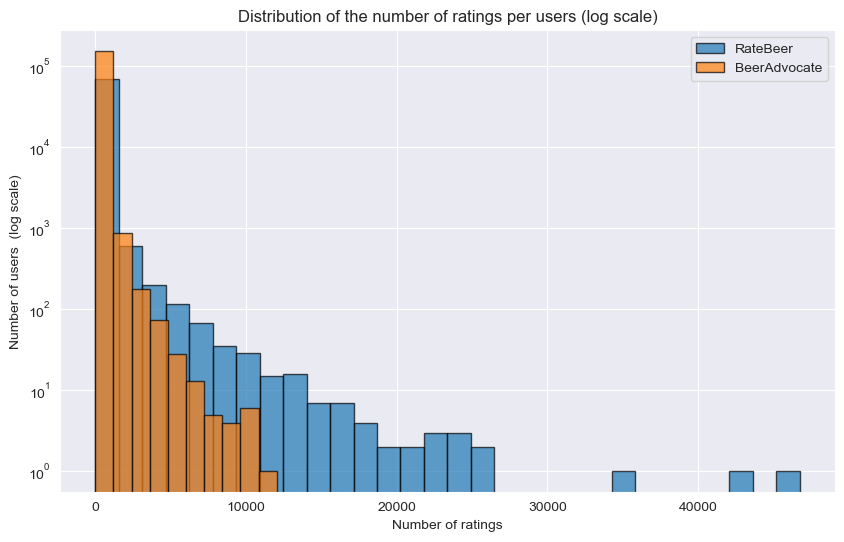

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(users_rb['nbr_ratings'], label = 'RateBeer', bins=30, edgecolor='k', alpha=0.7, log=True)
plt.hist(users_ba['nbr_ratings'], label = 'BeerAdvocate', bins=10, edgecolor='k', alpha=0.7, log=True)
plt.title('Distribution of the number of ratings per users (log scale)')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users  (log scale)')
plt.legend()
plt.show()

**Comment :** Some users rate more than 20'000 reviews! However, the log-scale on y-axis helps us to see that the majority of them rate only a few beers (otherwise we obtain a heavy-tailed plot). This gives us an idea about the distribution of users: we suppose that we have amateurs, rating only a few beers, and experts which rate many many beers. This will be dug further, as seasonal trends could be different between these two types of raters.

**3.2 Are raters also writers? Check nbr of reviews compared to nbr of ratings**

In [31]:
#BeerAdvocate
missing_values_text_ba = (user_ratings_ba['review'] == False).sum() 
missing_values_text_ba_perc = 100 * missing_values_text_ba / user_ratings_ba.shape[0]

In [32]:
#RateBeer
missing_values_text_rb = user_ratings_rb['text'].isna().sum()
missing_values_text_rb_perc = 100 *missing_values_text_rb / user_ratings_rb.shape[0]

In [33]:
print(f'We have {missing_values_text_ba} ratings without reviews in BeerAdvocate representing {missing_values_text_ba_perc:.2f}% of the total number of ratings')
print(f'We have {missing_values_text_rb} ratings without reviews in RateBeer representing {missing_values_text_rb_perc:.2f}% of the total number of ratings')

We have 5398276 ratings without reviews in BeerAdvocate representing 68.40% of the total number of ratings
We have 379 ratings without reviews in RateBeer representing 0.01% of the total number of ratings


**Comment :** For RateBeer, almost all the
ratings have a corresponding review, while many raters on BeerAdvocate did not gave their opinion.

**3.3 New column: country, to remove states in USA**

In [34]:
def extract_country(location):
    if ',' in location:
        # If there is a comma in the location, split the string and take the first part
        return location.split(',')[0].strip()
    else:
        # If there is no comma, return the original location
        return location.strip()

In [35]:
user_ratings_ba['country'] = user_ratings_ba['location'].apply(extract_country)
user_ratings_rb['country'] = user_ratings_rb['location'].apply(extract_country)

**3.4 Plot contribution of different countries in the % of ratings in Beer Advocate and RateBeer**

In [36]:
by_country_ba = (user_ratings_ba.groupby('country')['rating'].count()*100 / user_ratings_ba.shape[0]).sort_values(ascending=False)
by_country_rb = (user_ratings_rb.groupby('country')['rating'].count()*100 / user_ratings_rb.shape[0]).sort_values(ascending =False)
top_20_countries_ba = by_country_ba.nlargest(20)
top_20_countries_rb = by_country_rb.nlargest(20)

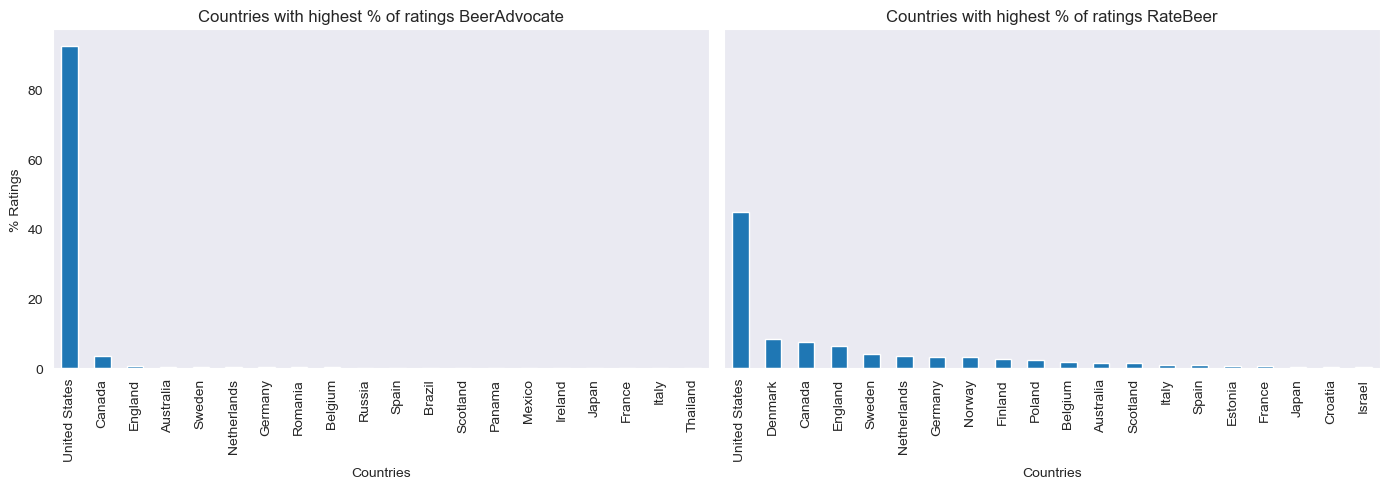

In [37]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize = (14,5), sharey = True)

top_20_countries_ba.plot(kind='bar', ax = axes[0])
axes[0].set_xlabel('Countries')
axes[0].set_ylabel('% Ratings')
axes[0].set_title('Countries with highest % of ratings BeerAdvocate')

top_20_countries_rb.plot(kind='bar', ax = axes[1])
axes[1].set_xlabel('Countries')
axes[1].set_title('Countries with highest % of ratings RateBeer')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

In [38]:
# DataFrames with precise values
df_ba = pd.DataFrame({'Country': top_20_countries_ba.index, '% of Ratings (BeerAdvocate)': top_20_countries_ba.values})
df_rb = pd.DataFrame({'Country': top_20_countries_rb.index, '% of Ratings (RateBeer)': top_20_countries_rb.values})

# Concatenate the two DataFrames along the columns axis
merged_df = pd.concat([df_ba, df_rb], axis=1)
merged_df

,Country,% of Ratings (BeerAdvocate),Country,% of Ratings (RateBeer)
0,United States,92.538929,United States,44.926574
1,Canada,3.478026,Denmark,8.409938
2,England,0.527028,Canada,7.553272
3,Australia,0.442368,England,6.370527
4,Sweden,0.379006,Sweden,4.096177
5,Netherlands,0.290798,Netherlands,3.377718
6,Germany,0.221216,Germany,3.161723
7,Romania,0.213145,Norway,3.134238
8,Belgium,0.208774,Finland,2.773087
9,Russia,0.133299,Poland,2.231056


**Comments :** Almost all the ratings in the BeerAdvocate data come from the United States (92.54%), whereas the United States contributes only half of the ratings in the RateBeer data (44.93%). The remaining half is more fairly distributed around the world.

**3.5 Mapping of ratings -> for a better vizualization**  
Note: if you cannot see the map, check File > Trust Notebook, or simply look at the .html files on the Git

In [39]:
map_ba = plot_map_ratings(user_ratings_ba)
map_ba.save('map_ba.html')
display(map_ba)

In [40]:
map_rb = plot_map_ratings(user_ratings_rb)
map_rb.save('map_rb.html')
display(map_rb)

**Comments :** As mentioned earlier, the USA constitutes the majority of ratings on BeerAdvocate and accounts for half of the entire dataset on RateBeer. Additionally, countries in Europe show increased activity in terms of ratings on RateBeer.

**3.6 What is the most rated style the whole world ?**

In [41]:
# in RateBeer
beer_style_counts = user_ratings_rb.groupby('style')['style'].agg('count')
beer_style_counts = beer_style_counts.sort_values (ascending=False)
top_20_beer_style = beer_style_counts.head(20)

# in BeerAdvocate
beer_style_counts_ba = user_ratings_ba.groupby('style')['style'].agg('count')
beer_style_counts_ba = beer_style_counts_ba.sort_values (ascending=False)
top_20_beer_style_ba = beer_style_counts_ba.head(20)

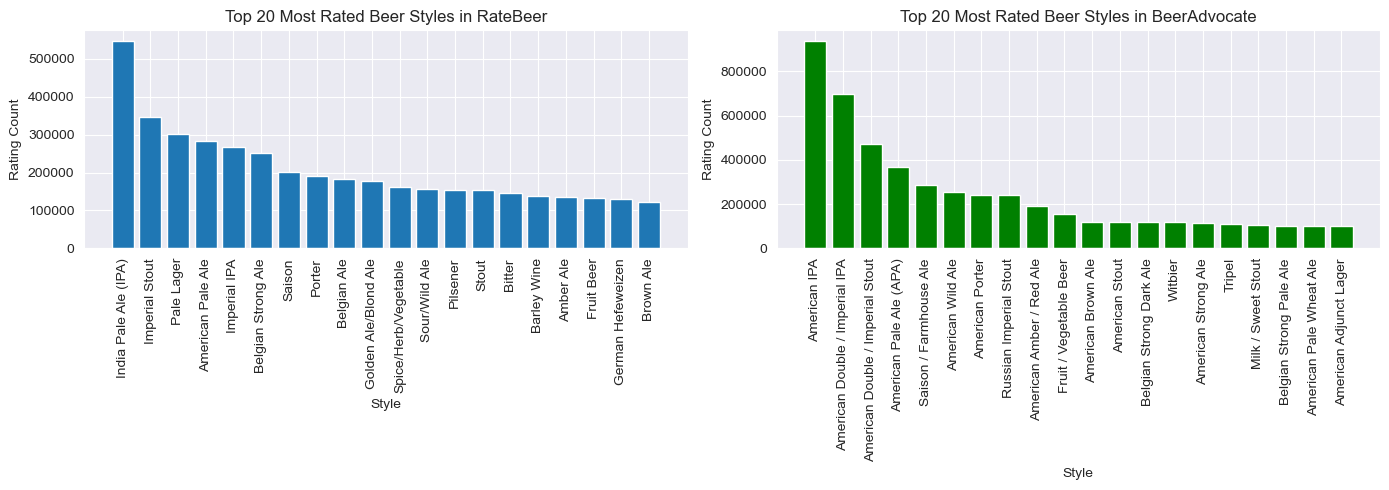

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the first bar chart for RateBeer
axes[0].bar(top_20_beer_style.index, top_20_beer_style.values)
axes[0].set_xlabel('Style')
axes[0].set_ylabel('Rating Count')
axes[0].set_title('Top 20 Most Rated Beer Styles in RateBeer')
axes[0].tick_params(axis='x', rotation=90)

# Plotting the second bar chart for BeerAdvocate
axes[1].bar(top_20_beer_style_ba.index, top_20_beer_style_ba.values, color = 'g')
axes[1].set_xlabel('Style')
axes[1].set_ylabel('Rating Count')
axes[1].set_title('Top 20 Most Rated Beer Styles in BeerAdvocate')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

**What about, especially in the ***US***? (as it constitutes the majority of the ratings in both datasets)**

In [43]:
# in RateBeer 
beer_style_counts_rb_us = user_ratings_rb[user_ratings_rb['country'] == 'United States'].groupby('style')['style'].agg('count')
beer_style_counts_rb_us = beer_style_counts_rb_us.sort_values (ascending=False)
top_20_beer_style_rb_us = beer_style_counts_rb_us.head(20)

# in BeerAdvocate
beer_style_counts_ba_us = user_ratings_ba[user_ratings_ba['country'] == 'United States'].groupby('style')['style'].agg('count')
beer_style_counts_ba_us = beer_style_counts_ba_us.sort_values (ascending=False)
top_20_beer_style_ba_us = beer_style_counts_ba_us.head(20)

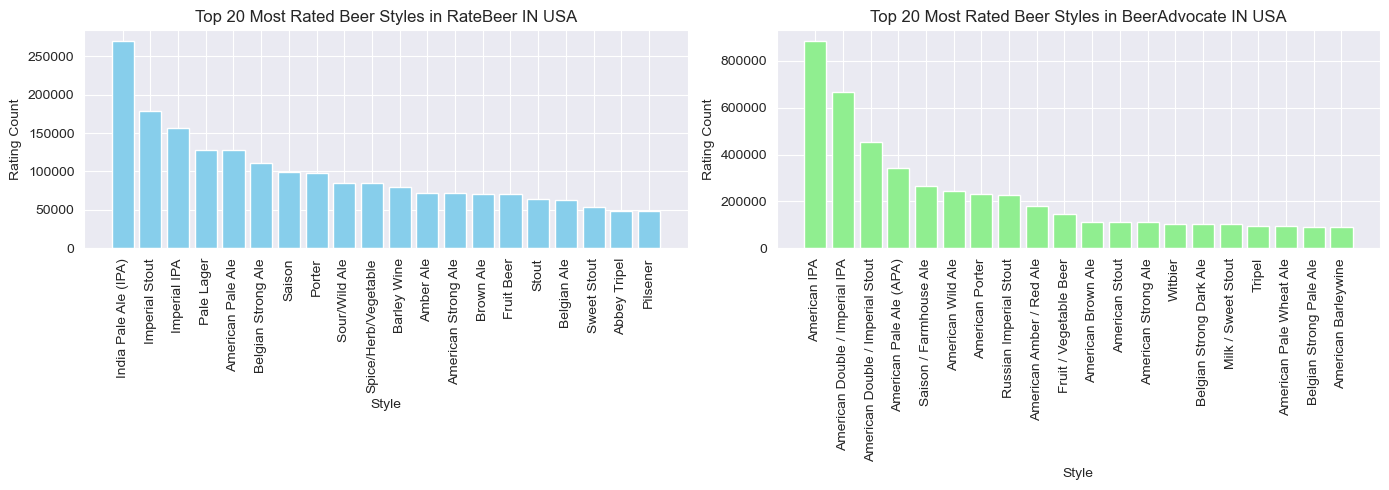

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the first bar chart for RateBeer
axes[0].bar(top_20_beer_style_rb_us.index, top_20_beer_style_rb_us.values, color='skyblue')
axes[0].set_xlabel('Style')
axes[0].set_ylabel('Rating Count')
axes[0].set_title('Top 20 Most Rated Beer Styles in RateBeer IN USA')
axes[0].tick_params(axis='x', rotation=90)

# Plotting the second bar chart for BeerAdvocate
axes[1].bar(top_20_beer_style_ba_us.index, top_20_beer_style_ba_us.values,color='lightgreen')
axes[1].set_xlabel('Style')
axes[1].set_ylabel('Rating Count')
axes[1].set_title('Top 20 Most Rated Beer Styles in BeerAdvocate IN USA')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

**Comments :** 
1. Some corresponding styles on both websites do not have exactly the same names. For example, we observe different types of IPA on *RateBeer*, such as 'India Pale Ale' and 'Imperial IPA,' while on *BeerAdvocate*, we find 'American IPA' and 'American Double / Imperial IPA'. 

> This discrepancy could make merging them challenging.

2. The top 12 beer styles worldwide are consistent with the most-rated styles in the USA when researching the *BeerAdvocate* dataset, as opposed to *RateBeer* where the similarity extends only to the top 2 styles. 

> Research on a global scale using *BeerAdvocate* may be biased due to its substantial amount of data from the USA.


**3.7 Supervised Learning : the relation between the features (*appearance, aroma, palate, taste, overall*) and response (*rating*)**


In [45]:
feature_cols = ['appearance', 'aroma','palate', 'taste', 'overall']

In [46]:
lin_reg = LinearRegression()  # create the model

In [47]:
#  check how many rows contain 'NaN' (missing values) in specific columns ('feature_cols') of a dataset
user_ratings_ba[feature_cols].isna().any(axis=1).sum()

3330980

In [48]:
#RateBeer
#New dataframe just for the supervised learning
user_ratings_rb_f_cols = user_ratings_rb.dropna(subset = feature_cols)
X_rb = user_ratings_rb_f_cols[feature_cols]
y_rb = user_ratings_rb_f_cols.rating

lin_reg.fit(X_rb, y_rb)  # train it

print('Value of rating in RateBeer is calculted by this following formula :')
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(lin_reg.coef_[f], feature_cols[f]))
print(lin_reg.intercept_)

Value of rating in RateBeer is calculted by this following formula :
0.09999945877735729 * appearance + 
0.0999994249812339 * aroma + 
0.10000022230188373 * palate + 
0.10000022586693079 * taste + 
0.10000010919534569 * overall + 
2.186165288797781e-06


In [49]:
#BeerAdvocate
user_ratings_ba_f_cols = user_ratings_ba.dropna(subset = feature_cols)
X_ba = user_ratings_ba_f_cols[feature_cols]
y_ba = user_ratings_ba_f_cols.rating

lin_reg.fit(X_ba, y_ba)  # train it

print('Value of rating in BeerAdvocate is calculted by this following formula :')
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(lin_reg.coef_[f], feature_cols[f]))
print(lin_reg.intercept_)

Value of rating in BeerAdvocate is calculted by this following formula :
0.060127936074310405 * appearance + 
0.24014376071374843 * aroma + 
0.10009737042022443 * palate + 
0.40011606456338655 * taste + 
0.19982273925031208 * overall + 
4.3855366540501706e-05


**Comment :** The calculation of the rating value differs across sites.

*RateBeer* assigns equal weights (~0.1 each) to calculate the rating score, distributing them uniformly among the criteria.

In contrast, *BeerAdvocate* places varying degrees of importance on each criterion :
- Taste ~0.4
- Aroma ~0.24
- Overall ~0.19
- Palate ~0.10
- Appearance ~0.06

Maybe the rating system for BeerAdvocate takes more into account the importance of each feature, but the RateBeer rating system is also valid.

**3.8 Do we have users in common for both datasets?**

In [50]:
# Merge the dataFrames 'users_ba' and 'users_rb' based on the 'user_name' column with an inner join
# The resulting DataFrame will contain only the rows where 'user_name' is common in both dataFrames
matched_users = pd.merge(users_ba, users_rb, on='user_name', how='inner')
display(matched_users)

,nbr_ratings_x,nbr_reviews,user_id_x,user_name,joined_x,location_x,nbr_ratings_y,user_id_y,joined_y,location_y
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington",3,101495,1.265800e+09,"United States, Washington"
1,1866,23,rochefortchris.697017,RochefortChris,1.349172e+09,"United States, North Carolina",8,213410,1.345975e+09,"United States, South Carolina"
2,6306,6306,brentk56.6284,brentk56,1.084442e+09,"United States, North Carolina",1,26838,1.125742e+09,"United States, North Carolina"
3,6260,4734,emerge077.17949,emerge077,1.113646e+09,"United States, Illinois",40,46216,1.165576e+09,"United States, Illinois"
4,1851,10,buckyp.435592,buckyp,1.267960e+09,"United States, South Carolina",20,68888,1.201864e+09,"United States, Georgia"
...,...,...,...,...,...,...,...,...,...,...
4344,1,1,cannile.407676,Cannile,NaN,NaN,11,45381,1.164020e+09,"United States, California"
4345,1,0,nogbadthebad.845220,NogbadTheBad,1.408010e+09,NaN,7,217518,1.347876e+09,"United States, Massachusetts"
4346,5,0,pagail118.566707,pagail118,1.297595e+09,Canada,1,118648,1.291720e+09,Canada
4347,1,1,brewfeller.850,brewfeller,1.033812e+09,"United States, Oklahoma",1,82734,1.223460e+09,"United States, Oklahoma"


**Comment :** We have raters which are the same for both datasets. It could be a problem for a potential merge, but we can remove them. However, it is probable that someone reviews on the both website with different usernames, and we have no way to identify them. It is another arguent to avoid merging the datasets.



>During the comparison of the *BeerAdvocate* and *RateBeer* datasets, we observed several critical points:
> - More than half (69.15%) of the total number of ratings on BeerAdvocate do not contain reviews, as opposed to 0.01% on RateBeer (see 3.2).
>- The majority of ratings come from the USA (see 3.4, 3.5).
>- Some corresponding beer styles on both websites do not have exactly the same names (see 3.6).
>- They have different methods for computing ratings based on their criteria, with BeerAdvocate placing more importance on 'taste' evaluation than 'appearance' (see 3.7).
>- Only a small community of users is subscribed to both sites (see 3.8).

>Even though we found a small community of users subscribed to both websites (4,349 users in common), due to the unequal distribution of ratings worldwide (90% in the USA for BeerAdvocate and 44% in the USA for RateBeer) and the differences in beer style names and rating computation methods, merging these two datasets seems very challenging.

>Therefore, keeping in mind that each dataset has its own pros and cons for obtaining specific information, the following exploration will be based on the ***RateBeer*** dataset, which has a more evenly distributed number of ratings across the world. However, we will tailor our research based on the specific information we require, determining which dataset is more suitable for our needs and adapting our observations (such as the way of calculating the rating score, review quality, etc.)

## 4. Exploration of the dataset RateBeer: Seasonal tendencies?

*To ensure that our project is feasible, the main goal is to find seasonal pattern amongst beers of the dataset in terms on popularity. To find those pattern we will apply the "Seasonal and Trend decomposition using Loess" (STL) method to the evolution of the number of ratings for different popular style of  beers. The STL method decompose a temporal series in 3 components : seasonal, trend and residuals. It's a outliers robust method that allows a clear visualisation of the evolution of the number of ratings.*

**4. 1 Distribution of ratings per month for all beers**

In [51]:
# filter the dataframe information from [01/01/2010;31/12/2016]
all_beer_all_world_rb = user_ratings_rb[
    (user_ratings_rb['year'] >= 2010) &
    (user_ratings_rb['year'] <= 2016)
]

In [52]:
all_beer_ratings_all_world_rb = all_beer_all_world_rb.groupby('year_month')["rating"].count()

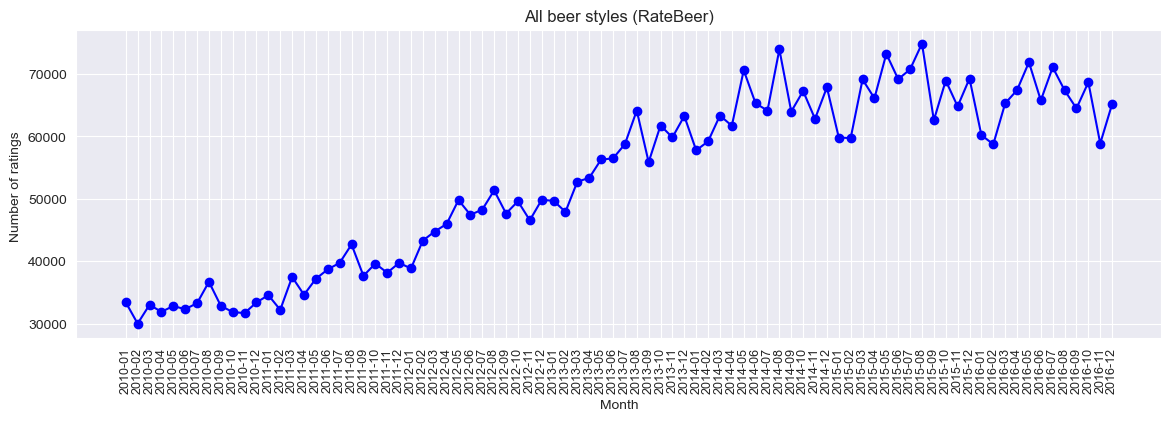

In [53]:
plt.figure(figsize = (14,4))
plt.plot(all_beer_ratings_all_world_rb.index.astype(str), all_beer_ratings_all_world_rb.values, marker = 'o', color = 'blue')
plt.xlabel('Month')
plt.ylabel('Number of ratings ')
plt.title('All beer styles (RateBeer)')
plt.xticks(rotation = 90, fontsize = 9)
#plt.ylim(0,75000)
plt.show()

**Comments :** We want to plot the evolution of the number of ratings for specific beer styles. However, we do not know if the evolution we will obtain for a specific beer style is the same as for all the beers (meaning that the evolution is not specific to the given style). That is why we needed to observe above the evolution of the number of ratings for all the beer styles, between 2010 and 2016.  
For specific beer styles, we will normalize according to the number of reviews for all beer styles

**4.2 Distribution of IPA, Pilsener, Belgian Strong Ale reviews normalized according to total number of reviews**

In [54]:
ipa_all_world_rb = all_beer_all_world_rb[(all_beer_all_world_rb['style'] == 'India Pale Ale (IPA)')]
ipa_ratings_per_month_all_world_rb = ipa_all_world_rb.groupby('year_month')["rating"].count()
ipa_ratings_perc_rb = ipa_ratings_per_month_all_world_rb / all_beer_ratings_all_world_rb

#Convert the index to timestamp
ipa_ratings_perc_rb.index = ipa_ratings_perc_rb.index.to_timestamp()

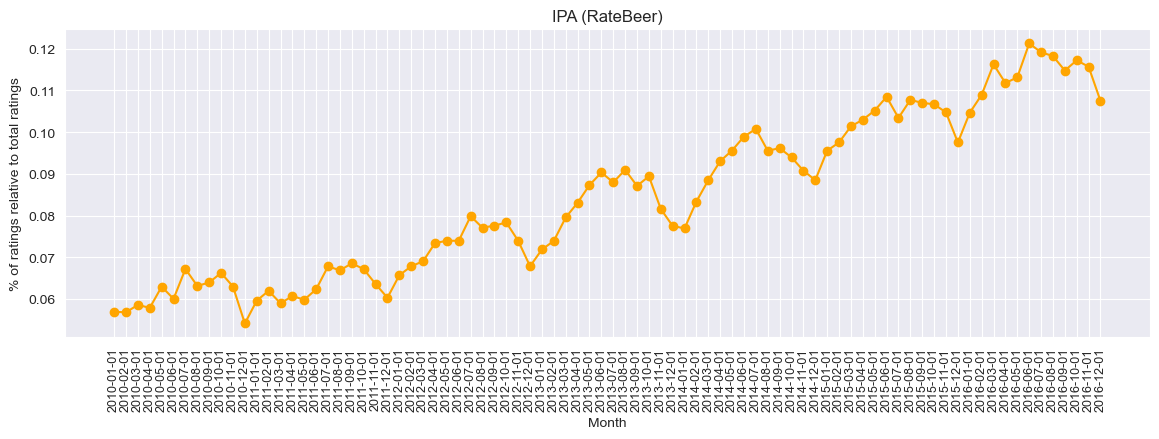

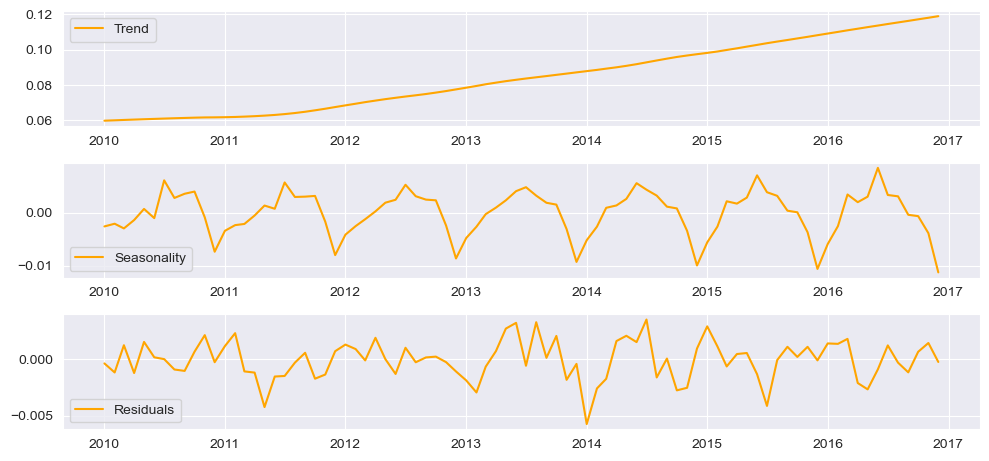

In [55]:
plt.figure(figsize = (14,4))
plt.plot(ipa_ratings_perc_rb.index.astype(str), ipa_ratings_perc_rb.values, marker = 'o', color = 'orange')
plt.xlabel('Month')
plt.ylabel('% of ratings relative to total ratings')
plt.title('IPA (RateBeer)')
plt.xticks(rotation = 90, fontsize = 9)
plt.show()
plot_STL(ipa_ratings_perc_rb, 'orange')

**Comment :**
Four graphs are displayed: 
1. the first one is the evolution of the number of ratings relative to total ratings of the IPA beers from January 2010 and December 2016. 
2. The second one is the trend of the first graph found by the STL algorithm. 
3. The third one represents the seasonality of the first graph found by the STL algorithm. 
4. The fourth one is the residuals  of the first graph found by the STL algorithm. 

**Observations :**
1. The first plot gives us some insights about the popularity of IPAs although it's not clear. The 3 remaining graphs gives more meaningfull insight about the data. 
2.  The trend plot shows that there is a constant increase in popularity. 
3.  The third graph gives the most interesting insight. The pattern becomes very clear in 2012. There is a clear decrease in popularity in winter that start in the middle of autumn and it becomes very popular in spring and in summer. 
4. The residuals graph gives the information that the pattern found are meaningfull. As the range of the residuals is smaller than the seasonality graph it means that there is not much noise and that the pattern found is meaningfull.

## Pilsener

In [56]:
pilsener = all_beer_all_world_rb[(all_beer_all_world_rb['style'] == 'Pilsener')]
pilsener_per_month_all_world_rb = pilsener.groupby('year_month')["rating"].count()
pilsener_ratings_perc_rb = pilsener_per_month_all_world_rb / all_beer_ratings_all_world_rb

# Convert the index to timestamp
pilsener_ratings_perc_rb.index = pilsener_ratings_perc_rb.index.to_timestamp()

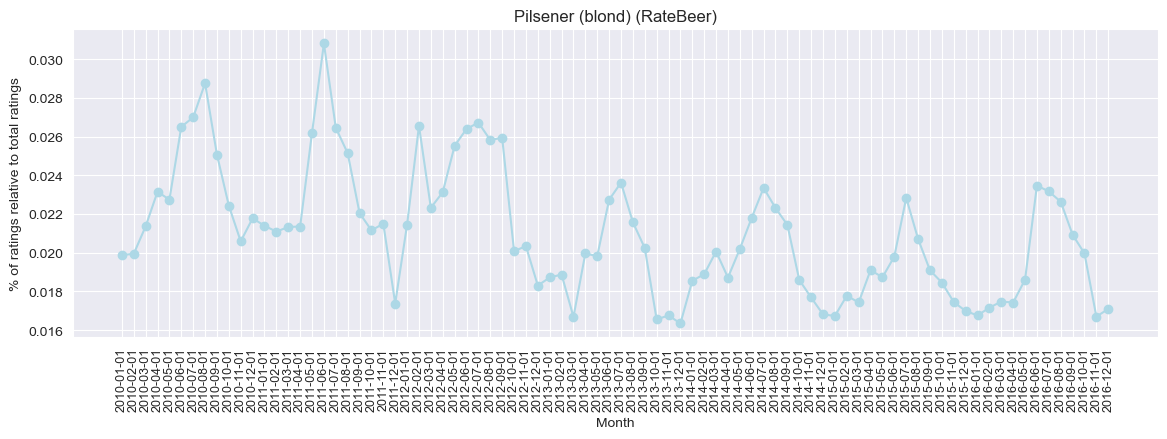

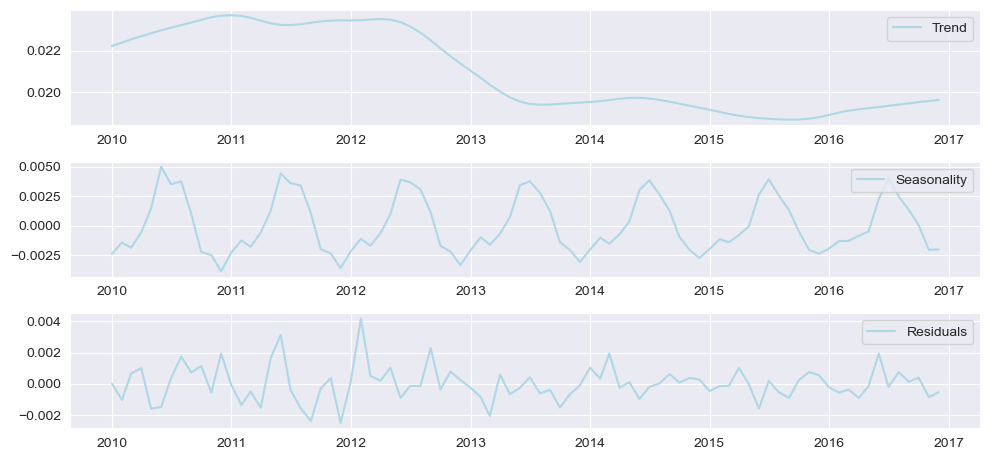

In [57]:
plt.figure(figsize = (14,4))
#plt.plot(pilsener_ratings_per_month.index.astype(str), pilsener_ratings_per_month.values, marker = 'o')
plt.plot(pilsener_ratings_perc_rb.index.astype(str), pilsener_ratings_perc_rb.values, marker = 'o', color = 'lightblue')
plt.xlabel('Month')
plt.ylabel('% of ratings relative to total ratings')
plt.title('Pilsener (blond) (RateBeer)')
plt.xticks(rotation = 90, fontsize = 9)
plt.show()
plot_STL(pilsener_ratings_perc_rb, 'lightblue')

**Observations :** As the plots for the IPAs, we see that for the pilsener beers there is a rather constant increase in popularity before it becomes constant in 2014. The seasonality graph gives a clear pattern, summer is the season where it's the most popular and winter is the season where it's the least popular. The residuals plot shows that the result of the seasonality plot is meaningfull.

## Belgian Strong Ale

In [58]:
belg_strong_ale_rb = all_beer_all_world_rb[(all_beer_all_world_rb['style'] == 'Belgian Strong Ale')]
belg_strong_ale_per_month_all_world_rb = belg_strong_ale_rb.groupby('year_month')["rating"].count()
belg_strong_ale_ratings_perc_rb = belg_strong_ale_per_month_all_world_rb / all_beer_ratings_all_world_rb

# Convert the index to timestamp
belg_strong_ale_ratings_perc_rb.index = belg_strong_ale_ratings_perc_rb.index.to_timestamp()

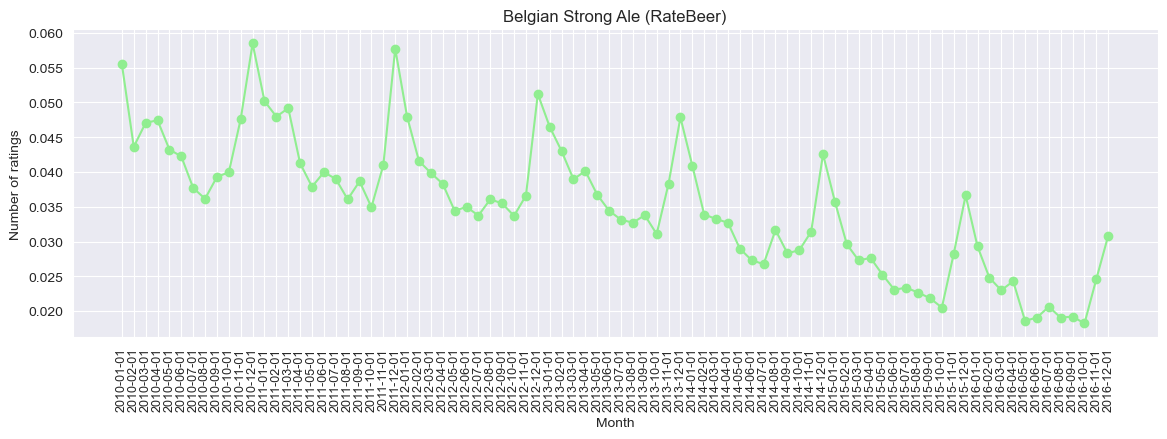

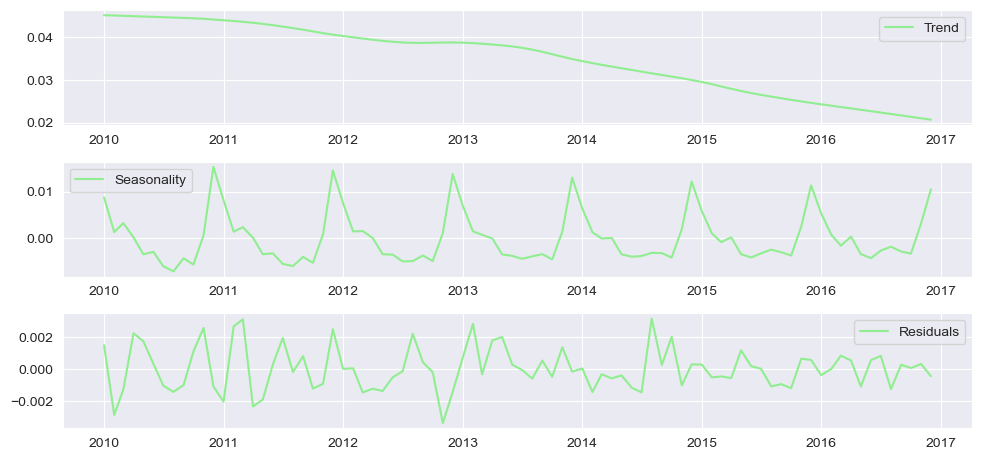

In [59]:
plt.figure(figsize = (14,4))
#plt.plot(belg_strong_ale_ratings_per_month.index.astype(str), belg_strong_ale_ratings_per_month.values, marker = 'o')
plt.plot(belg_strong_ale_ratings_perc_rb.index.astype(str), belg_strong_ale_ratings_perc_rb.values, marker = 'o', color = 'lightgreen')
plt.xlabel('Month')
plt.ylabel('Number of ratings')
plt.title('Belgian Strong Ale (RateBeer)')
plt.xticks(rotation = 90, fontsize = 9)
plt.show()
plot_STL(belg_strong_ale_ratings_perc_rb, 'lightgreen')

**Observations :** The trend plot shows that the popularity of the Belgian strong ale (BSA) increase from 2010 until the end of 2013 and decrease from that moment. The seasonality plot shows a clear pattern. On the opposite of the the IPA and the pilsener, the BSA becomes very popular every december. Although, the range of the residuals values is closer to the range of the range of seasonality plot values the pattern found relates to the original plot. It allows to say that the result is meaningfull.

*We see that the pattern found are different between style of beers but it would be interesting to understand theses causes to ensure that those pattern are not random. One of the characteristics that is interesting to see that, is to look at the difference of alcohol percentage in those beer styles that could explain tendencies during the year.*

**4.3 Distribution of alcohol degree among two different beer styles**

In [60]:
beers_less_15_rb = beers_rb[beers_rb['abv'] <= 15]

In [61]:
pils = beers_less_15_rb[beers_less_15_rb['style'] == 'Pilsener']
bsa = beers_less_15_rb[beers_less_15_rb['style'] == 'Belgian Strong Ale']
ipa = beers_less_15_rb[beers_less_15_rb['style'] == 'India Pale Ale (IPA)']

In [62]:
pils.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
55,526621,Boundary Generic,22818,Boundary,Pilsener,1,NaN,NaN,2.89,5.0,2.80,NaN,0,NaN
214,360989,Mourne Mountains Mourne Mist,23165,Mourne Mountains Brewery,Pilsener,1,NaN,NaN,3.00,4.5,3.30,-0.412028,1,3.3
255,368965,Walled City Kicks,24866,Walled City,Pilsener,1,NaN,NaN,3.00,4.1,3.30,NaN,0,NaN
303,457548,AdstraGold Oaky Pilsner Premium,15008,AdstraGold Microbrewery & Bistro Bar,Pilsener,2,NaN,NaN,2.81,3.5,2.60,NaN,0,NaN
304,224981,AdstraGold Pilsner Premium,15008,AdstraGold Microbrewery & Bistro Bar,Pilsener,5,NaN,NaN,2.78,3.0,2.22,NaN,0,NaN


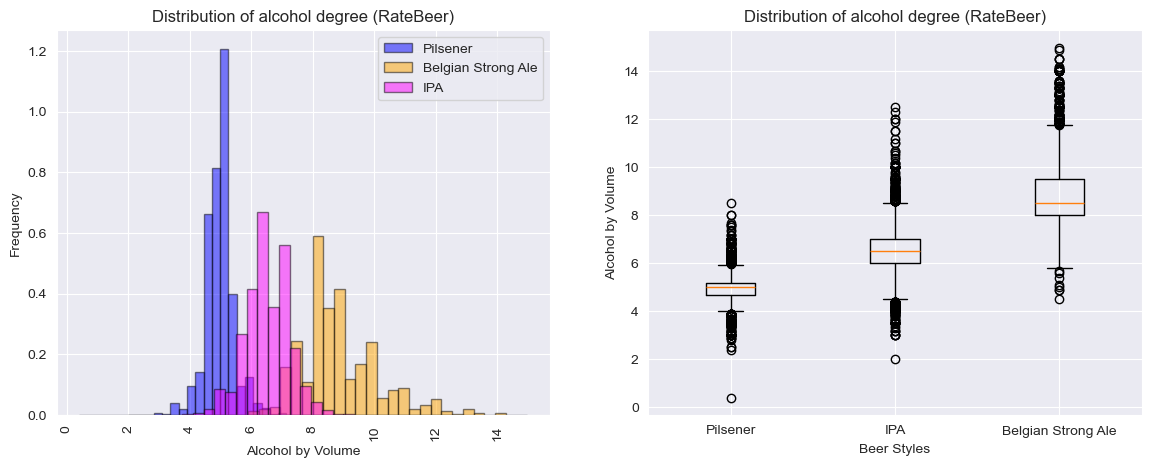

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Histogram
axes[0].hist(pils['abv'], bins = 30, color = 'blue', label = 'Pilsener', density = True, alpha = 0.5, edgecolor = 'black')
axes[0].hist(bsa['abv'], bins = 30, color = 'orange', label = 'Belgian Strong Ale', density = True, alpha = 0.5, edgecolor = 'black')
axes[0].hist(ipa['abv'], bins = 30, color = 'magenta', label = 'IPA', density = True, alpha = 0.5, edgecolor = 'black')
axes[0].set_xlabel('Alcohol by Volume')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of alcohol degree (RateBeer)')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend()

#Boxplot
axes[1].boxplot([pils['abv'], ipa['abv'], bsa['abv']], labels=['Pilsener', 'IPA' ,'Belgian Strong Ale'])
axes[1].set_xlabel('Beer Styles')
axes[1].set_ylabel('Alcohol by Volume')
axes[1].set_title('Distribution of alcohol degree (RateBeer)')

plt.show()

**Comments :** We see with on this plot, that, there is a huge difference in the distribution of alcohol degree between IPA, Belgian Strong Ale and the Pilsener. The BSA are stronger than IPAs which are generally stronger than Pilseners. Therefore there is a potential cause of the difference of patterns between those beers. We can make the hypothesis that **people tend to drink beers with a high degree of alcohol in winter** and that **people drink lighter beer in spring and summer**. We would need to analyse further to either confirm or infirm this statement.

**Conclusion**

Throughout this preliminary analysis of the dataset we found results and issues that needs to be addressed. We found different pattern for different popular styles of beers and have some hypothesis to explain those pattern that remains to be tested. 

The main issues that we saw concerns mainly the **merge of the datasets** from BeerAdvocate and RateBeer and the different type of users. We do not know how the merge can affect our preliminary results. 

We also did not analyze the results based on the location of the users as the pattern can change from one population to another and as seasons are not the same between earth hemispheres. 

However, those results show that there is a lot of potential in the analysis of the seasonal popularity of beers, the causes of it and what it implies.

*****This Project is Not Just Possible, It's Feasible!*****